In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
using LaTeXStrings
using Printf
using LsqFit

In [2]:
include("aux_functions.jl")

reorder_particles!

#### Primero hacemos el caso undamped

## A esto hay que cambiarlo todo!

In [ ]:
run_name = "landau_big_8_5t100_L39.738_N8_5_J3522_M1001_o5_T3"
#run_name = "landau_big_8_5t100_L39.738_N2_5_J3522_M1001_o5_T3"
(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/" * run_name * "results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");

p
length(S_T)

In [ ]:
@show (L, N, J, κ, dx, order) = p

exp_Theta = 3 #this can be read from run_name
exp_t = 2 #this can be read from run_name
θ = 10.0^(-exp_Theta)
t = 0.0
t_f = 10.0^(exp_t)
M = 1001 #this can be read from run_name
M_g = 1000 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)
t_i = 0.0

x = [dx*(i-1) for i in 1:J] ;

println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")

animation = false


In [ ]:
#save(run_name * "results.jld2", Dict("p" => p, "Energy_E" => Energy_E, "Energy_K" => Energy_K, "E_f" => u[2N+1:end], "n_F" => n_F, "S_F" => S_F, "E_T"=> E_T, "v_T" => v_T, "S_T" => S_T, "D_T" => D_T, "T" => T))

In [ ]:
plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation (order = $(order))", label = "Kinetic Energy"
#, legend = :outertopright
, legend = :bottomright)
plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|")
plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1]) 
, yscale=:log10
#, xscale=:log10
, label = "Total Energy / Initial Energy -1 ")
#png(run_name * "energy_conservation")

In [ ]:
abs.(Energy_K[end]  + Energy_E[end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1])

In [ ]:
plot(T, label= "θ", title = "Temperature = var", legend = false)

#png(run_name * "temperature")

In [ ]:
T[end]
#length(T)

In [ ]:
t_series = [dt*(i-1)*(M-1)/(M_g-1) for i in 1:M_g];

Since we are fitting the temperature and that is like the velocity square we need to approximate it with the square of a wave.

In [ ]:
p0 = [0.1, 60., 1.0, 0.0] #, 0.0, 0.0]
@. model(x, p) = p[1] + p[2]*cos(x*p[3] + p[4])^2 #*cos(x*p[5] + p[6])

In [ ]:
fit = curve_fit(model, t_series, Energy_E, p0);
fit.param

For these parámeters the fit is:

`[1.0009490930490625
 67.82701283760936
  1.0002810154957107
  0.00019119530305159043]`


In [ ]:
cov = estimate_covar(fit)

#sqrt(Diagonal(cov))

#margin_of_error = margin_error(fit, 0.1)


#confidence_intervals = confidence_interval(fit, 0.1)

The cov matrix is:
 
 `2.20767e-15  -2.94447e-15   7.41979e-17  -1.00864e-14
 -2.94447e-15   5.90124e-15   4.20125e-17  -1.29548e-14
  7.41979e-17   4.20125e-17   8.49937e-13  -8.49403e-11
 -1.00864e-14  -1.29548e-14  -8.49403e-11   1.13183e-8`

In [ ]:
#plot(t_series, T, label= "θ", title = "Temperature = var", legend = false)
plot(t_series, Energy_E, label= "θ", title = "Electric Energy", legend = false)
#scatter!(t_series, model(t_series, fit.param), markersize = 1)
plot!(t_series, model(t_series, fit.param),ls=:dash)

In [ ]:
E_F = zeros(J)
ϕ_F = zeros(J)
#n_F = zeros(J)
#get_density!(u, n_F, p)
n0 = N/L
get_ϕ!(ϕ_F, n_F/n0 .+ 1, κ)
#get_ϕ!(ϕ_F, n_F .- n0, κ)
get_E_from_ϕ!(ϕ_F,E_F,dx)
plot(x,E_f, label = "dynamical", title="Electric Field with order = $(order)")
plot!(x,E_F,label="from constraint", ls=:dash)
#t_f = 40
#png(run_name * "E")

In [ ]:
plot(layout=(2,2), title="order = $(order)")
plot!(subplot=1,E_T,title="Total Electric Field (order = $(order))")
plot!(subplot=2,v_T./N, title="Total velocity (order = $(order))")
plot!(subplot=3,D_T,title = "Total density (order = $(order))")
plot!(subplot=4,S_T,title = "Total Current (order = $(order))")
#png(run_name * "totals")

### Ahora chequeamos con damping ###

In [6]:

#file_name = "Results/landau_damped_rel_t40_L7.455_N8_5_J930_M1601_o5_T3.jld2"
file_name = "Results/landau_damped_rel_t400_L7.455_N8_5_J930_M16001_o5_T3.jld2"



data = load(file_name);
run_name = data["run_name"]
par_grid = data["par_grid"]
par_evolv = data["par_evolv"]
par_f = data["p_Ini"]
@show (N, L, J, dx, order) = par_grid
@show (t_i, t_f, M, M_g, dt) = par_evolv
@show (θ, nm, κ) = par_f

n0 = N/L

x = [(i-1)*dx for i in 1:J]

dT = dt * (M-1) / (M_g-1)

t_series = [(i-1)*dT for i in 1:M_g]

#M_g = 501 



(N, L, J, dx, order) = par_grid = (800000, 7.455, 930, 0.008016129032258065, 5)
(t_i, t_f, M, M_g, dt) = par_evolv = (0.0, 400.0, 16001, 1601, 0.025)
(θ, nm, κ) = par_f = (0.001, 15, 0.8428149305405213)


1601-element Vector{Float64}:
   0.0
   0.25
   0.5
   0.75
   1.0
   1.25
   1.5
   1.75
   2.0
   2.25
   2.5
   2.75
   3.0
   ⋮
 397.25
 397.5
 397.75
 398.0
 398.25
 398.5
 398.75
 399.0
 399.25
 399.5
 399.75
 400.0

In [7]:



v = zeros(2N+J,M_g)

for j in 1:M_g
    tiempo = @sprintf("%05d", j)
    v[:,j] = data["u/u_$tiempo"]
end

#run = Dict("p"=>p, "Energy_E"=>Energy_E, "Energy_K"=>Energy_K, "E_f"=>E_f, "n_F"=>n_F,  "S_F"=>S_F, "E_T"=>E_T, "v_T"=>v_T, "S_T"=>S_T, "D_T"=>D_T, "T"=>T)

#(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T)
#p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/landau_damped_t200_L7.455_N8_4_J930_M2001_o5_T3th20_results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");

#(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/landau_dumped_t100_L7.455_N2_5_J930_M1001_o5_T3th1_results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");
#data_d  = load("Results/landau_damped_t400_L7.455_N8_4_J930_M16001_o5_T3th4_results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");


In [8]:
#(L, N, J, κ, dx, order) = data_d["p"]

exp_Theta = 3 #this can be read from run_name
exp_t = 2 #this can be read from run_name
θ = 10.0^(-exp_Theta)
t = 0.0
e = 1
m = 1

animation = false
plots = true


true

In [ ]:
v[2N+1:end,1]
x

In [9]:
if plots 
    ofset = 0.001
    plt = plot(label="Electric Field", legend=false)
    for j in 1:5:M_g
        plt = plot!(x,1e0*v[2N+1:end,j].+ofset*j)
    end
    plt
    #png("Images/" * run_name * _electric_field")
end

In [20]:
ρ_f = zeros(J)
E_f = zeros(J)
E_i = v[2N+1:end,1]
ϕ_f = zeros(J)
S_f = zeros(J)

j = M_g

p = (L, N, J, κ, dx, order)
get_density!(v[:,j], ρ_f, p)
get_ϕ!(ϕ_f, ρ_f/n0 .+ 1, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)

if plots
    plot(x,E_f,label="from final density", ls=:dash, lw=2)
    plot!(x,E_i,label="E_initial")
    plot!(x,v[2N+1:end,j], label="E_final"
    )

    png("Efield_th$(nthreads())_" * run_name)
end


In [12]:
Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
EField_T = zeros(M_g)
p_T = zeros(M_g)
Q_T = zeros(M_g)
S_T = zeros(M_g)
E_E = 0.0
E_K = zeros(J)
P = zeros(J)
ρ = zeros(J)
S = zeros(J)

for j in 1:M_g
    (Energy_K[j],Energy_E[j]) = get_energy_rel(v[:,j],(L,N,J))
    EField_T[j] = sum(v[2N+1:end,j])*dx
    #p_T[j] = sum(get_momentum!(v[:,j],P,(Nx, dx, Np, dp)))*dx
    get_density!(v[:,j], ρ, p)
    get_current_rel!(v[:,j], S, p)
    Q_T[j] = get_total_charge(ρ,(J, dx))
    S_T[j] = sum(S)/N/Q_T[j]
end

In [97]:
if plots 
    factor = 200
    plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E[1:end] .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, Q_T/N .- 1, label="charge")
    plot!(subplot=4, S_T, label="Total Current")

    png("Images/"  * run_name * "_total_run")
end

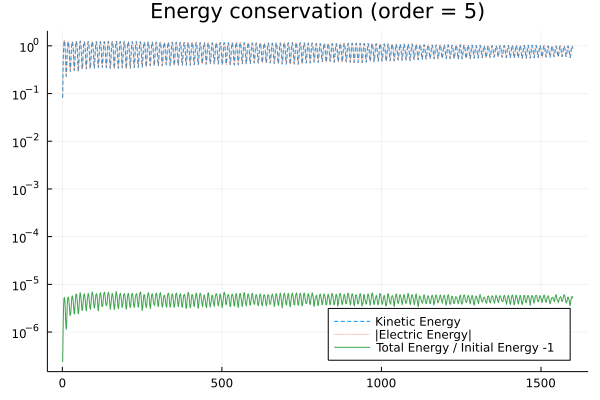

In [75]:


plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation (order = $(order))", label = "Kinetic Energy"
#, legend = :outertopright
, legend = :bottomright, ls=:dash)
plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|", ls=:dot)
plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1] + Energy_E[1])
, yscale=:log10
#, xscale=:log10
, label = "Total Energy / Initial Energy -1 ")
#png("Images/" * run_name * "energy_conservation")

In [54]:
T = [var(v[N+1:2N,j]) for j in 1:M_g]

plot(t_series,T, label= "θ", title = "Temperature = var", legend = false)
#png("Images/" * run_name * "temperature")

In [47]:
p0 = [0.001, 0.005, 1.0, -π/2, 0.000, 0.0, 0.0, 0.0]
p1 = [0.001, 0.005, 2.0, -π/2, 0.000, 2.0, 0.0, 0.002]
@. model_0(x, p) = p[1] + (p[2]*cos(x*p[3] + p[4]))^2 #*cos(x*p[5] + p[6])
@. model_1(x, p) = p[1] + (p[2]*cos(x*p[3] + p[4]) + p[5]*cos(x*p[6] + p[7]))*exp(-p[8]*x) #*cos(x*p[5] + p[6])

model_1 (generic function with 1 method)

In [48]:
fit_0 = curve_fit(model_0, t_series, T, p0);
fit_0.param

8-element Vector{Float64}:
  0.0010013354356785864
  0.0013022885624546037
  1.002764628087659
 -1.5324483387857684
  0.0
  0.0
  0.0
  0.0

In [49]:
fit_1 = curve_fit(model_1, t_series, T, p1);
fit_1.param

8-element Vector{Float64}:
  0.0010021838741618213
  1.2444250813938006e-6
  2.0055161553588188
 -3.0625410242253617
 -1.2886397169576128e-9
 -6.689277532196627
  0.7713562064904245
  0.00205542799597902

In [56]:
Plots.scatter(t_series, T, label= "θ", title = "Temperature = var", legend = false, xlim=(300,400), ms=2)
#plot!(t_series, model_0(t_series, fit_0.param), markersize = 1, lable="simple fit")
plot!(t_series, model_1(t_series, fit_1.param), markersize = 1)
#png("Images/" * run_name * "temperature_fit_closeup")


In [ ]:
cov = estimate_covar(fit)

In [37]:
#plot(t_series, (T .- fit.param[1]).*exp.(-fit.param[5] .* t_series))
plot(t_series, Ttf.*exp.(0.0020769924816417553.* t_series))

LoadError: UndefVarError: Ttf not defined

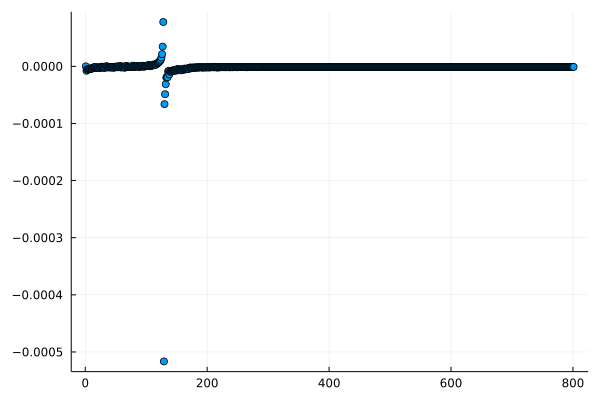

In [79]:
Tft = T .- sum(T)/length(T)
#Th = rfft(Ttf.*exp.(0.0020769924816417553.* t_series))
Th = rfft(Tft)
Plots.scatter(real.(Th)
    #,xlim=(0,200)
    #,ylim=(-0.01,0.01)
    ,label=false
    )

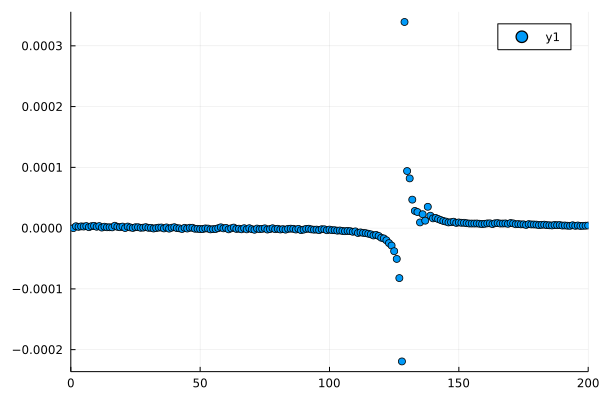

In [80]:
Plots.scatter(imag.(Th)
    ,xlim=(0,200)
    )

#### The Electric Energy

In [94]:
@. model_e1(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x)
@. model_e2(x,p) = p[1] + p[2]*(cos(p[3]*x + p[4])^2-p[6])*exp(-p[5]*x)
pe1 = [1.0; 1; 2; 2; 0.002]
pe2 = [1.0; 1; 1; 0; 0.002; 0.5]

fit_energy_1 = curve_fit(model_e1, t_series, Energy_E, pe1);
fit_energy_2 = curve_fit(model_e2, t_series, Energy_E, pe2);
fit_energy_1.param
fit_energy_2.param

6-element Vector{Float64}:
 0.5426368300321007
 0.9957761955753025
 1.0027574956243372
 0.03965166857942542
 0.002057259870931431
 0.4734534164003081

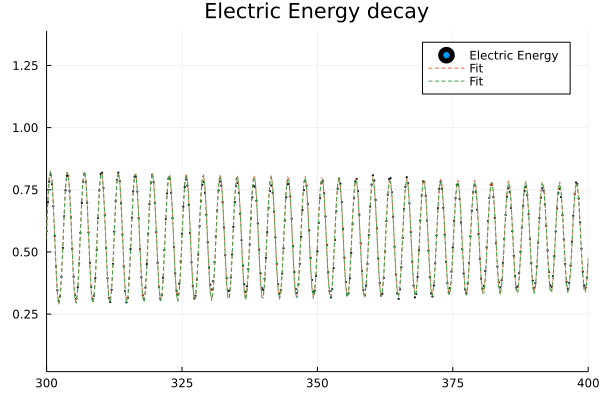

In [96]:
Plots.scatter(t_series,Energy_E
    , markersize=1
    , title = "Electric Energy decay"
    , label= "Electric Energy"
    #, yscale=:log10
    )

plot!(t_series,model_e1(t_series,fit_energy_1.param), ls=:dash
, markersize = 0.2
#, xlims=(00,400)
, label="Fit"
)
plot!(t_series,model_e2(t_series,fit_energy_2.param), ls=:dash
, markersize = 0.2
, xlims=(300,400)
, label="Fit"
)
#png("Images/" * run_name * "_energy_fit")


La frecuencia parece estar en $\omega = 1.00184$

In [ ]:
E_F = zeros(J)
ϕ_F = zeros(J)
#n_F = zeros(J)
#get_density!(u, n_F, p)
n0 = N/L
get_ϕ!(ϕ_F, data_d["n_F"]/n0 .+ 1, κ)
#get_ϕ!(ϕ_F, n_F .- n0, κ)
get_E_from_ϕ!(ϕ_F,E_F,dx)
plot(x,data_d["E_f"], label = "dynamical", title="Electric Field with order = $(order)")
plot!(x,E_F,label="from constraint", ls=:dash)
#t_f = 40
#png(run_name * "E")

In [ ]:
plot(layout=(2,2), title="order = $(order)")
plot!(subplot=1,t_series,data_d["E_T"],title="Total Electric Field (order = $(order))")
plot!(subplot=2,t_series,data_d["v_T"]./N, title="Total velocity (order = $(order))")
plot!(subplot=3,t_series,data_d["D_T"],title = "Total density (order = $(order))")
plot!(subplot=4,t_series,data_d["S_T"],title = "Total Current (order = $(order))")
#png(run_name * "totals")


In [ ]:
plot(data_d["S_F"])